In [19]:
import torch
import torchvision
import numpy as np
import wandb
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from models.mnist.mnist_net import MnistNet
from datasets.mnist_dataset import MNISTDataset
from utils.dataset_utils import train_test_split, get_transformation
from utils.visualization import print_label_distribution
from models.mnist.gating_network import FMGate, MnistNetGate
import matplotlib.pyplot as plt



In [20]:
# Set seeds
torch.manual_seed(42)
np.random.seed(42)

# Define transformations
transformations_mnist_default = get_transformation('mnist')
transformations_mnist_swiss = get_transformation('swiss_mnist')

# Load datasets
mnist_default_train = MNISTDataset(
    '../../../data/default_mnist/training', transform=transformations_mnist_default)
mnist_default_test = MNISTDataset(
    '../../../data/default_mnist/testing', transform=transformations_mnist_default)

mnist_swiss_train = MNISTDataset(
    '../../../data/swiss_mnist/training', transform=transformations_mnist_swiss)
mnist_swiss_test = MNISTDataset(
    '../../../data/swiss_mnist/testing', transform=transformations_mnist_swiss)

# Subsample default MNIST
mnist_default_train, _ = train_test_split(mnist_default_train, proportions=[
                                          len(mnist_swiss_train) / len(mnist_default_train), 0])
mnist_default_test, _ = train_test_split(mnist_default_test, proportions=[
                                         len(mnist_swiss_test) / len(mnist_default_test), 0])

# Combine datasets
combined_train = torch.utils.data.ConcatDataset([mnist_swiss_train, mnist_default_train])
combined_test = torch.utils.data.ConcatDataset([mnist_swiss_test, mnist_default_test])


In [21]:
run_paths_swiss_experts = ['lukas-struppek/mnist_tests/fcdowae5', 'lukas-struppek/mnist_tests/2auoixlr', 'lukas-struppek/mnist_tests/13jvtaes']
checkpoints_swiss_experts = ['swiss_expert ' + str(i) + '_final.tar' for i in range(3)]

run_paths_default_experts = ['lukas-struppek/mnist_tests/2psy0oo3', 'lukas-struppek/mnist_tests/1tr4hz9h', 'lukas-struppek/mnist_tests/2i47h9dq']
checkpoints_default_experts = ['mnist_expert' + str(i) + '_final.tar' for i in range(3)]

run_paths_fmgates = ['lukas-struppek/mnist_tests/1kcvxxpq', 'lukas-struppek/mnist_tests/jmabi1ho', 'lukas-struppek/mnist_tests/1hg2ur69']
checkpoints_fmgates = ['FMNet ' + str(i) + '_final.tar' for i in range(3)]

run_paths_mnistnetgates = ['lukas-struppek/mnist_tests/15lybst1', 'lukas-struppek/mnist_tests/3rp7ty3g', 'lukas-struppek/mnist_tests/9mdzbqnl']
checkpoints_mnistnetgates = ['MnistNetGate ' + str(i) + '_final.tar' for i in range(3)]

swiss_experts = []
for i in range(3):
    model = MnistNet(classes=[i for i in range(10)])
    file = wandb.restore(checkpoints_swiss_experts[i], run_path=run_paths_swiss_experts[i])
    model.load_state_dict(torch.load(file.name)['model_state_dict'])
    swiss_experts.append(model)

default_experts = []
for i in range(3):
    model = MnistNet(classes=[i for i in range(10)])
    file = wandb.restore(checkpoints_default_experts[i], run_path=run_paths_default_experts[i])
    model.load_state_dict(torch.load(file.name)['model_state_dict'])
    default_experts.append(model)

fm_gates = []
for i in range(3):
    model = FMGate(classes=[i for i in range(10)], experts=[swiss_experts[i], default_experts[i]], name='FMNet_' + str(i) )
    file = wandb.restore(checkpoints_fmgates[i], run_path=run_paths_fmgates[i])
    model.load_state_dict(torch.load(file.name)['model_state_dict'])
    fm_gates.append(model)

mnistnet_gates = []
for i in range(3):
    model = MnistNetGate(classes=[i for i in range(10)], experts=[swiss_experts[i], default_experts[i]], name='MnistNetGate_' + str(i) )
    file = wandb.restore(checkpoints_mnistnetgates[i], run_path=run_paths_mnistnetgates[i])
    model.load_state_dict(torch.load(file.name)['model_state_dict'])
    mnistnet_gates.append(model)


## Average weighting

In [22]:
weights = np.zeros((3,2))
for i, fm_gate in enumerate(fm_gates):
    dataloader = torch.utils.data.DataLoader(combined_test, batch_size=128)
    fm_gate.to(fm_gate.device)
    fm_gate.eval()
    with torch.no_grad():
        for (image, label) in dataloader:
            image = image.to(fm_gate.device)
            weights[i] += fm_gate.forward(image, output_only=False)['weights'].sum(dim=0).cpu().numpy()
weights_fmgate = np.array(weights) / len(combined_test)

In [23]:
weights = np.zeros((3,2))
for i, mnistnet_gate in enumerate(mnistnet_gates):
    dataloader = torch.utils.data.DataLoader(combined_test, batch_size=128)
    mnistnet_gate.to(mnistnet_gate.device)
    mnistnet_gate.eval()
    with torch.no_grad():
        for (image, label) in dataloader:
            image = image.to(mnistnet_gate.device)
            weights[i] += mnistnet_gate.forward(image, output_only=False)['weights'].sum(dim=0).cpu().numpy()
weights_mnistgate = np.array(weights.data) / len(combined_test)

In [24]:
weights_mnistgate.mean(axis=0)

array([0.52145397, 0.47854604])

In [25]:
weights_fmgate.mean(axis=0)

array([0.50787593, 0.49212407])

## Plot average top weighted samples

In [32]:
def plot_highest_weighted_samples(gates, testset, expert_weight):
    dataframes = []
    for i in range(len(gates)):
        dataframes.append(gates[i].get_highest_weighted_examples(testset))
    df_concat = pd.concat(dataframes)
    top30 = df_concat.sort_values(by=[expert_weight], ascending=False)[:30]
    top30.drop_duplicates(subset ="sample_index", keep = 'first', inplace=True) 

    # plot images
    top_10_indices = top30.sort_values(by=[expert_weight], ascending=False)['sample_index'][:10]
    top_10_weights = top30.sort_values(by=[expert_weight], ascending=False)[expert_weight][:10]
    sns.set_style("dark")
    fig, axes = plt.subplots(1, 10, figsize=(10, 2))
    indices = top_10_indices.values.tolist()

    for j in range(10):
        text = str(top30.iloc[j]['prediction'][0]) + ' (' + str(int(top30.iloc[j]['label'])) + ')'
        axes[j].imshow(testset[indices[j]][0].squeeze(), cmap='gray_r', interpolation='nearest')
        axes[j].text(4, 0, text, fontdict={'fontsize': 12, 'fontweight': 'bold'})
        axes[j].set_title(np.round(top_10_weights.iloc[j], 4), fontdict={'fontsize': 12, 'fontweight': 'bold'}, pad=-60)
        axes[j].set_xticks([])
        axes[j].set_yticks([])


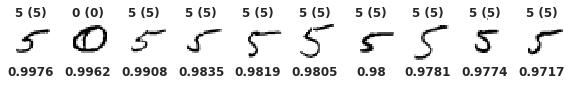

In [34]:
plot_highest_weighted_samples(fm_gates, mnist_default_test, 'weight expert 0')

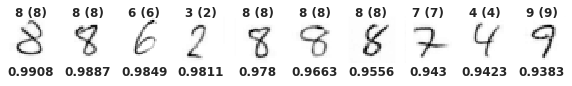

In [35]:
plot_highest_weighted_samples(fm_gates, mnist_swiss_test, 'weight expert 1')

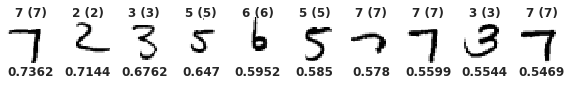

In [36]:
plot_highest_weighted_samples(mnistnet_gates, mnist_default_test, 'weight expert 0')

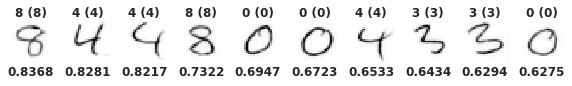

In [37]:
plot_highest_weighted_samples(mnistnet_gates, mnist_swiss_test, 'weight expert 1')

## Analyzing only first run

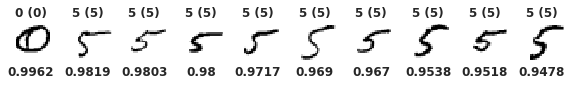

In [38]:
plot_highest_weighted_samples([fm_gates[1]], mnist_default_test, 'weight expert 0')

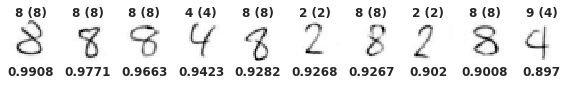

In [39]:
plot_highest_weighted_samples([fm_gates[1]], mnist_swiss_test, 'weight expert 1')

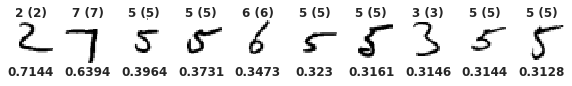

In [40]:
plot_highest_weighted_samples([mnistnet_gates[1]], mnist_default_test, 'weight expert 0')

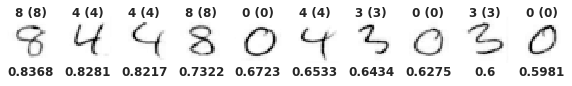

In [41]:
plot_highest_weighted_samples([mnistnet_gates[1]], mnist_swiss_test, 'weight expert 1')